The Kepler full frame images contain extremely long cadence data that we can use to create long cadence, long baseline light curves for anything in the Kepler field of view, like AGN. However, spacecraft systematics dominate these data, and while Kepler provided tools for getting around these in the short cadence light curves that were the mission's main data products, no such tool exists for the FFIs.

But we can work around this. By generating the light curves of a large number of sources near an object of interest, we can perform a principal component analysis on the data. Since spacecraft systematics should be correlated across the detector, by removing the strongest components, we should also be able to remove the systematics, providing nice, corrected light curves!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.backend_bases import MouseButton
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.stats import mad_std
from astropy import units as u
from astropy import wcs
from astroquery.simbad import Simbad
from astroquery.ned import Ned
from os import listdir
from photutils import aperture_photometry, CircularAperture, EllipticalAperture, DAOStarFinder
import requests
import csv

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


First, just a few classes we will use to manage our FFI files and lightcurves.

In [2]:
class KeplerFFIFile:
    def __init__(self, path):
        self.path = path
        self.hdu = fits.open(self.path)
        
        time_header = self.hdu[1].header
        self.time = (time_header['MJDSTART'] + time_header['MJDEND']) / 2
    
    def channel_header(self, channel):
        return self.hdu[channel].header
    
    def channel_data(self, channel):
        return self.hdu[channel].data
    
    def channel_containing(self, skycoords):
        channels = []
        for channel in range(1, len(self.hdu)):
            data = self.channel_data(channel)
            dims = data.shape
            try:
                pixel_coords = self.sky_to_pixel(skycoords, channel)
                if pixel_coords[0] <= dims[1] and pixel_coords[0] >= 0 and pixel_coords[1] <= dims[0] and pixel_coords[1] >= 0:
                    return channel
            except LookupError:
                continue
        raise LookupError('No channel contains these coordinates.')
        
    def sky_to_pixel(self, skycoords, channel):
        w = wcs.WCS(self.channel_header(channel))
        if w.has_celestial:
            pixel = wcs.utils.skycoord_to_pixel(skycoords, w)
            x = float(pixel[0])
            y = float(pixel[1])
            return (x, y)
        else:
            raise LookupError('Coordinates not located on channel.')
    
    def pixel_to_sky(self, x, y, channel):
        w = wcs.WCS(self.channel_header(channel))
        if w.has_celestial:
            return wcs.utils.pixel_to_skycoord(x, y, w, mode='wcs')
        else:
            raise LookupError('Channel does not contain sky coordinates.')
    

In [3]:
class LightCurve:
    def __init__(self, time=[], flux=[], flux_err=[], name=None):
        self.time = time
        self.flux = flux
        self.flux_err = flux_err
        self.name = name
    
    def append_time(self, t):
        self.time.append(t)
    
    def append_flux(self, f):
        self.flux.append(f)
    
    def append_flux_err(self, err):
        self.flux_err.append(err)
    
    def clear(self):
        self.time = []
        self.flux = []
        self.flux_err = []
    
    def plot(self):
        plt.plot(self.time, self.flux)
        plt.scatter(self.time, self.flux)
        plt.xlabel('time (MJD)')
        plt.ylabel('flux (cts/cadence)')
        plt.title(self.name)
    
    def save(self):
        with open('{}.csv'.format(self.name), 'w+', newline='') as file:
            writer = csv.writer(file, delimiter=',')
            writer.writerow(['time', 'flux', 'flux_err'])
            for i in range(0, len(self.time)):
                writer.writerow([self.time[i], self.flux[i], self.flux_err[i]])

A few helpful functions.

In [4]:
# Returns a skycoord object containing the coordinates of a KIC object.
def search_kic(kic):
    try:
        result_table = Simbad.query_object('KIC {}'.format(kic))
        ra = result_table['RA'][0]
        dec = result_table['DEC'][0]
    except IndexError:
        result_table = Ned.query_object("KIC {}".format(kic))
        ra = result_table['RA'][0]
        dec = result_table['DEC'][0]
    
    sky = SkyCoord(ra=ra, dec=dec, unit=(u.hourangle, u.deg), equinox='J2000', frame='icrs')
    
    return sky

In [5]:
# Returns a tuple of paths to FFIs and error FFIs from a certain quarter.
def get_ffis_from_quarter(quarter):
    image_folder = 'ffis/' + str(quarter)

    ffis = []
    err_ffis = []
    for file in listdir(image_folder + '/data/'):
        ffis.append(KeplerFFIFile(image_folder + '/data/' + file))

    for file in listdir(image_folder + '/uncert/'):
        err_ffis.append(KeplerFFIFile(image_folder + '/uncert/' + file))
        
    return (ffis, err_ffis)

In [6]:
# Gets a cycle of 4 channels a source will be present in, rotating by quarter.
def get_channel_cycle(coords):
    channels = []
    for i in range(2, 6):
        ffis, err_ffis = get_ffis_from_quarter(i)
        channels.append(ffis[0].channel_containing(coords))

    return channels

To get an idea of where we're looking in the sky (and, more importantly, on the detector), we first tell the program which Kepler object we care about. We use astropy to locate all sufficiently bright stars within a certain radius of the object (we use 200 pixels here).

In [7]:
kic = 11614932 # Edit here to change the KIC number.
skycoords = search_kic(kic)
print(skycoords)

<SkyCoord (ICRS): (ra, dec) in deg
    (294.01282917, 49.6046525)>


In [8]:
ffis, err_ffis = get_ffis_from_quarter(2)
ffi = ffis[0]
channel = ffi.channel_containing(skycoords)
agn_centroid = ffi.sky_to_pixel(skycoords, channel)
data = ffi.channel_data(channel)
bkg_sigma = mad_std(data)
daofind = DAOStarFinder(fwhm=4., threshold=100.*bkg_sigma)
sources = daofind.find_stars(data)

In [9]:
close_sources = []
for source in sources:
    source_location = (source['xcentroid'], source['ycentroid'])
    if np.sqrt((source_location[0] - agn_centroid[0])**2
                + (source_location[1] - agn_centroid[1])**2) <= 200:
        close_sources.append(source)        
positions = [(close_sources[i]['xcentroid'], close_sources[i]['ycentroid']) for i in range(0,len(close_sources))]

In [10]:
sky_positions = []
for coord in positions:
    sky_positions.append(ffi.pixel_to_sky(coord[0], coord[1], channel))

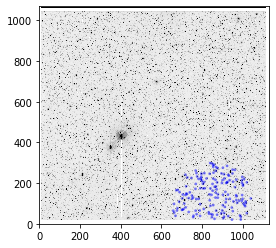

In [11]:
aps = CircularAperture(positions, r=3.)
%matplotlib inline
plt.imshow(data, cmap='gray_r', origin='lower', norm=LogNorm(vmin=100, vmax=10000))
#plt.xlim(agn_centroid[0] - 50, agn_centroid[0] + 50)
#plt.ylim(agn_centroid[1] - 50, agn_centroid[1] + 50)
aps.plot(color='blue', lw=1.5, alpha=0.5)
plt.show()

Next, we generate light curves for every source we detected near our AGN. We will use them as a training set for our PCA fit, which we will then apply to just the AGN light curve. This is the most computationally intensive part of the pipeline and takes the most time to run, but you only need to do it once per AGN.

In [12]:
lightcurves = []
source_number = 1
for source in sky_positions:
    times = []
    fluxes = []
    try:
        channels = get_channel_cycle(source)
    except LookupError:
        print('Source failed.')
        source_number += 1
        continue
    channel_index = 0
    for quarter in range(2,17):
        ffis, err_ffis = get_ffis_from_quarter(quarter)
        for i in range(0, len(ffis)):
            try:
                ffi = ffis[i]
                channel = channels[channel_index]
                data = ffi.channel_data(channel)
                centroid = ffi.sky_to_pixel(source, channel)
                time = ffi.time
                times.append(time)
                ap = CircularAperture(centroid, r=3.)
                phot_table = aperture_photometry(data, ap)
                flux = phot_table['aperture_sum'][0]
                fluxes.append(flux)
            except LookupError:
                continue
        channel_index += 1
        channel_index %= 4
    lightcurves.append(LightCurve(time=times, flux=fluxes))
    print('Source completed: {}/{}'.format(source_number, len(sky_positions)))
    source_number += 1

Source completed: 1/156
Source completed: 2/156
Source completed: 3/156
Source completed: 4/156
Source completed: 5/156
Source completed: 6/156
Source completed: 7/156
Source completed: 8/156
Source completed: 9/156
Source completed: 10/156
Source completed: 11/156
Source completed: 12/156
Source completed: 13/156
Source completed: 14/156
Source completed: 15/156
Source completed: 16/156
Source completed: 17/156
Source completed: 18/156
Source completed: 19/156
Source completed: 20/156
Source completed: 21/156
Source completed: 22/156
Source completed: 23/156
Source completed: 24/156
Source completed: 25/156
Source completed: 26/156
Source completed: 27/156
Source completed: 28/156
Source completed: 29/156
Source completed: 30/156
Source completed: 31/156
Source completed: 32/156
Source completed: 33/156
Source completed: 34/156
Source completed: 35/156
Source completed: 36/156
Source completed: 37/156
Source completed: 38/156
Source completed: 39/156
Source completed: 40/156
Source co

After gathering our training data, we use Scikit Learn to fit it to a PCA model. We reduce the dimensionality of our training data and then reproject it to the original space to see how effective our model is. The number of leading principal components we omit is arbitrary and can vary up to the number of sources in our training data. The more we omit, the more we detrend the data, but the greater the risk of overfitting.

In [13]:
from sklearn.decomposition import PCA


y = lightcurves[0].time
x = np.array([])
num_samples = 0
for lc in lightcurves:
    ok = True
    for i in lc.flux:
        if np.isnan(i) or i < 0:
            ok = False
            break
    if ok is False:
        continue
    x = np.append(x, np.array(lc.flux))
    num_samples += 1

sample_length = len(y)
x = np.reshape(x, (num_samples, sample_length))
mu = np.mean(x, axis=1)

# Reduce dimensionality of the dataset and reproject onto the original
# space leaving out the first n_comp principal components. This gets rid
# of cotrending features in the data, i.e. spacecraft systematics.
pca = PCA()
pca.fit(x)

# Number of components to exclude. INCREASE THIS TO INCREASE THE STRENGTH OF CORRECTIONS.
n_comp = 10

n_included = sample_length - n_comp
print('n = {}'.format(n_included))

x_hat = np.dot(pca.transform(x)[:,n_comp:], pca.components_[n_comp:,:])
x_hat = np.transpose(x_hat)
x_hat += mu
x_hat = np.transpose(x_hat)

n = 34


Below, we plot the raw/corrected pairs of light curves from the first twenty objects in our training data. This can give us a good qualitative feel for how effective our fit was. Star light curves should be as flat as possible.

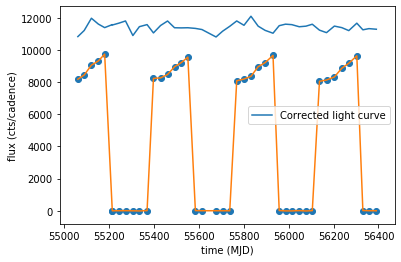

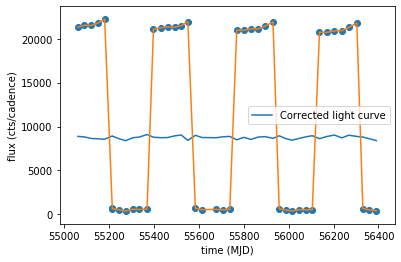

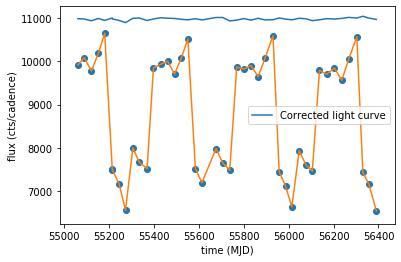

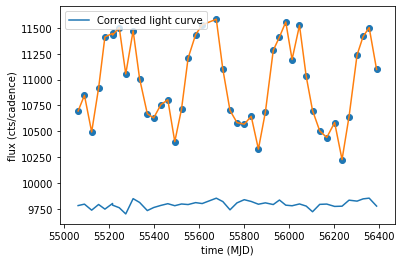

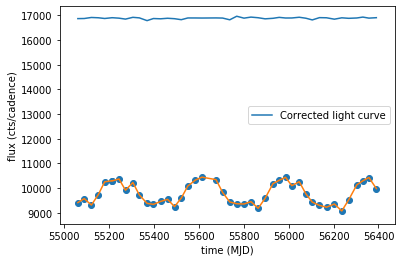

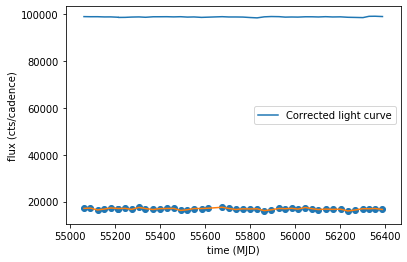

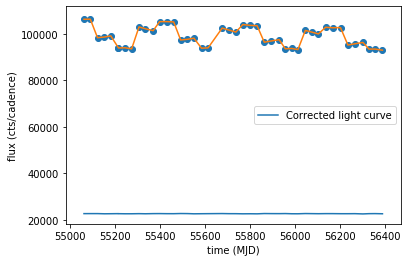

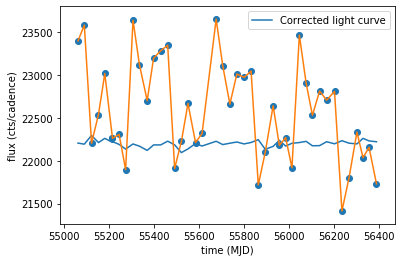

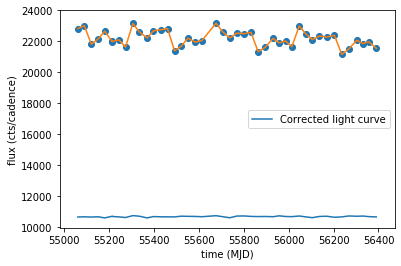

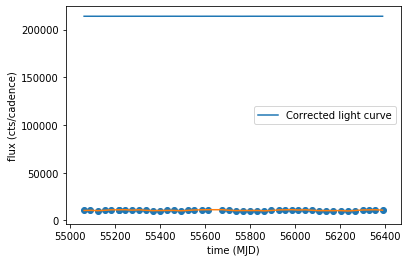

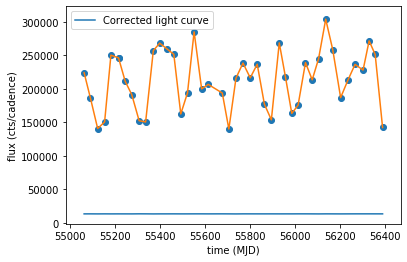

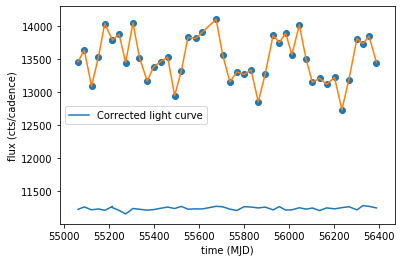

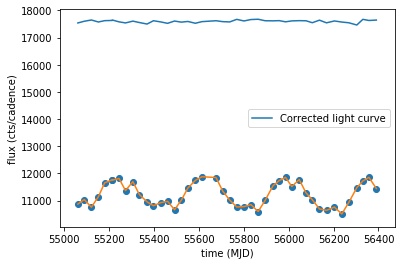

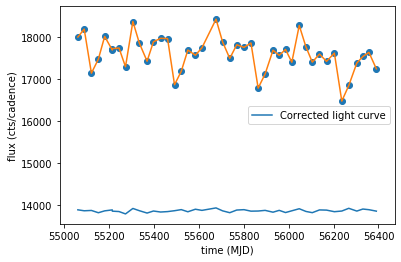

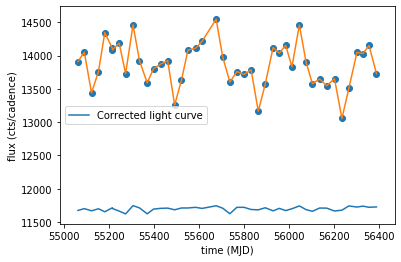

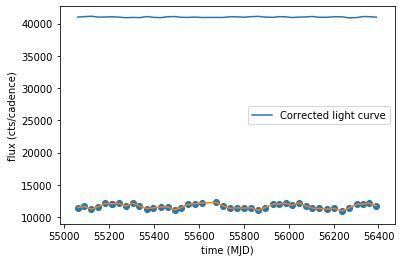

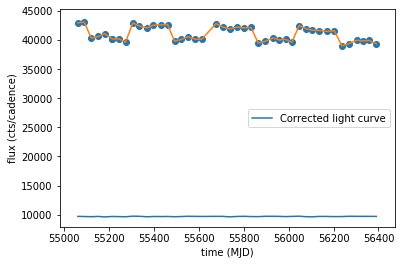

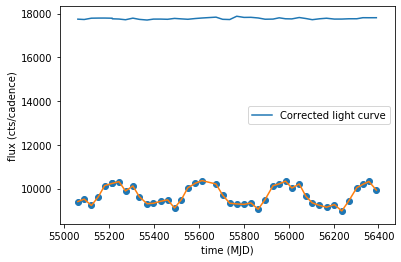

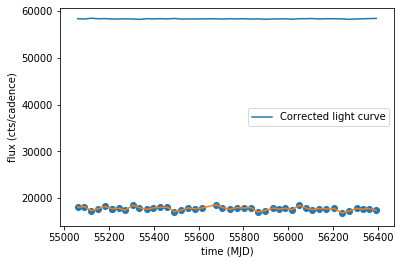

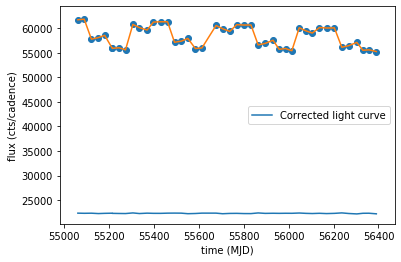

In [14]:
%matplotlib inline
for i in range(0,20):
    plt.plot(y, x_hat[i], label='Corrected light curve')
    lightcurves[i].plot()
    plt.legend()
    plt.show()

Not all of the light curves correct to something nice and flat. This is mostly because automatic aperture selection can only go so far. Some of the apertures were too big, too small, or shaped wrong, which messes with our photometry. However, due to the large number of samples, the anomalies are negligible, especially in the first few principal components.

Below, we select an aperture for our AGN target, plot its light curve, and correct it.

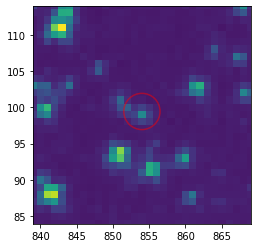

In [15]:
display_quarter = 2
ffi = get_ffis_from_quarter(display_quarter)[0][0]
channel = ffi.channel_containing(skycoords)
data = ffi.channel_data(channel)
centroid = ffi.sky_to_pixel(skycoords, channel)

radius = 2.5 # Radius of the circular aperture
# Change these offset values to fine-tune the position of the aperture in case the centroid Kepler gave us
# isn't quite optimal.
x_offset = 0
y_offset = -0.5

ap = CircularAperture((centroid[0]+x_offset, centroid[1]-y_offset), r=radius)
plt.imshow(data, norm=LogNorm(vmin=100, vmax=10000))
plt.xlim(centroid[0] - 15, centroid[0] + 15)
plt.ylim(centroid[1] - 15, centroid[1] + 15)
ap.plot(color='red', lw=1.5, alpha=0.5)

In [16]:
lc = LightCurve(name='KIC {} raw'.format(str(kic)))
lc.clear()

channels = get_channel_cycle(skycoords)
channel_index = 0
for quarter in range(2,17):
    ffis, err_ffis = get_ffis_from_quarter(quarter)
    for i in range(0, len(ffis)):
        try:
            ffi = ffis[i]
            err_ffi = err_ffis[i]
            channel = channels[channel_index]
            if channel is -1:
                continue
            data = ffi.channel_data(channel)
            sq_err_data = np.square(err_ffi.channel_data(channel))
            centroid = ffi.sky_to_pixel(skycoords, channel)
            time = ffi.time
            lc.append_time(time)
            ap = CircularAperture((centroid[0]+x_offset, centroid[1]+y_offset), r=radius)
            phot_table = aperture_photometry(data, ap)
            flux = phot_table['aperture_sum'][0]
            lc.append_flux(flux)
            err_phot_table = aperture_photometry(sq_err_data, ap)
            err_flux = err_phot_table['aperture_sum'][0]
            lc.append_flux_err(np.sqrt(err_flux))
        except LookupError:
            continue
    channel_index += 1
    channel_index %= 4

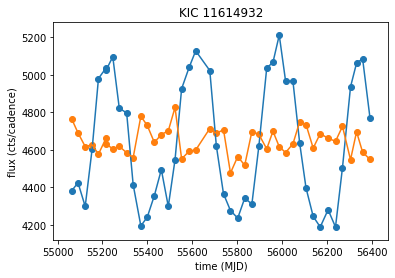

In [17]:
raw = np.array(lc.flux)
raw = np.reshape(raw, (1, -1))
mu = np.mean(raw)
corrected = np.dot(pca.transform(raw)[:,n_comp:], pca.components_[n_comp:,:])
corrected = np.transpose(corrected)
corrected += mu
corrected = np.reshape(np.transpose(corrected), (sample_length,))

lc_corrected = LightCurve(lc.time, corrected, lc.flux_err, name='KIC {}'.format(str(kic)))
lc_corrected.save()
lc.save()

lc.plot()
lc_corrected.plot()
plt.show()